### VGG-16 transfer learning

Here we'll look at using the VGG-16 network, which is pre-trained from the ImageNet challenge data (http://www.image-net.org/challenges/LSVRC/), along with the transfer learning technique to train a classifier for MNIST. This is a bit of overkill for a simple dataset like MNIST, where creating our own network and training from scratch can make sense, since we have many examples of each class, and the images are relatively small. Indeed in the last section we saw we can achieve 99% accuracy with a simple neural network. However, the same techniques can be applied to more complex datasets, as is left in a challenge at the bottom of this Jupyter notebook.

In [31]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20

%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

from keras.applications import xception, vgg16, vgg19, mobilenet
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Convolution2D, ZeroPadding2D, BatchNormalization, Input, concatenate
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.utils import np_utils, multi_gpu_model
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
from keras import backend as K
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import log_loss, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import mnist

Let's import MNISt and do the same pre-processing of the data we did before to get it in an appropriate form.

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.reshape((60000,28,28,1))
x_test = x_test.reshape((10000,28,28,1))

In [5]:
y_train_enc = keras.utils.to_categorical(y_train)
y_test_enc = keras.utils.to_categorical(y_test)

### Define the processing parameters

In [11]:
batch_size = 128

We'll use the same scaling here, as VGG-16 wants to see images scaled in the same way with values from 0 to 1 as inputs.

In [12]:
# train_datagen = ImageDataGenerator(
#         rotation_range=40,
#         rescale=1./255,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        x_train,  
        y_train_enc,
        batch_size=batch_size)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow(
        x_test,
        y_test_enc,
        batch_size=batch_size)

### Switch to transfer learning approach

In [13]:
#################################################################
############## Transfer Model 1 #################################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(28, 28, 1))

# Notice that we did not include the top of the neural network, which is the set of densely connected
# layers that where used to convert the output of the convolutional layers that find image features
# into the 1000 classes of the ImageNet dataset

# add a global spatial average pooling layer
x = base_model.output

### We need a normalization layer here to get the model output in a form we can send to a dense layer $$$
# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add fully-connected layers, using dropout as a way to keep the network
# from overfitting to the training data (regularization)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer, which will output probabilities from 0 to 1
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG-16 layers, which have already been trained
# to perform well on the ImageNet dataset
for layer in base_model.layers:
    layer.trainable = False

### We use 
model_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer=mypotim, loss='binary_crossentropy', metrics=["accuracy"])

ValueError: The input must have 3 channels; got `input_shape=(28, 28, 1)`

So we can see that while last time we defined everything about our network, so the inputs could be whatever size we wanted, for transfer learning we must respect the original network size a bit more.

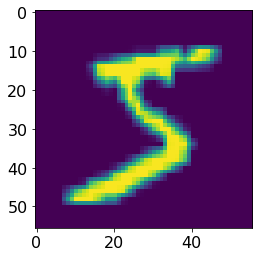

In [71]:
plt.imshow(tsti)

In [14]:
num_images, image_x, image_y, channels = x_train.shape
new_shape = (num_images, image_x, image_y, 3)
x_train_3c = np.zeros(new_shape)

In [15]:
x_train_3c[:,:,:,0] = x_train[:,:,:,0]
x_train_3c[:,:,:,1] = x_train[:,:,:,0]
x_train_3c[:,:,:,2] = x_train[:,:,:,0]

In [16]:
#################################################################
############## Transfer Model 1 (Fixed) #########################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(28, 28, 3))


# add a global spatial average pooling layer
x = base_model.output

# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer=mypotim, loss='binary_crossentropy', metrics=["accuracy"])

ValueError: Input size must be at least 48x48; got `input_shape=(28, 28, 3)`

So now we have the wrong shape, the model can't take images at that low of resolution. With a bit of work we can get around this, let's hope it's worth it in the end! This took a bit of figuring with SciPy's two-dimensional interpolation function, please see the associated docs here: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html

In [17]:
from scipy.interpolate import interp2d

In [18]:
#### This all took about 30 seconds to run on the Paperspace VM
orig_x_ind = range(image_x)
orig_y_ind = range(image_y)

new_x_values = np.arange(0, image_x, 0.5)
new_y_values = np.arange(0, image_y, 0.5)

new_shape_exp = (num_images, len(new_x_values), len(new_y_values), 3)

x_train_3c_exp = np.zeros(new_shape_exp)

for i in range(x_train.shape[0]):
    
    interp_fn = interp2d(orig_x_ind, orig_y_ind, x_train[i,:,:,0])
    
    interp_image = interp_fn(new_x_values, new_y_values)
    
    x_train_3c_exp[i, :, :, 0] = interp_image 
    x_train_3c_exp[i, :, :, 1] = interp_image 
    x_train_3c_exp[i, :, :, 2] = interp_image 

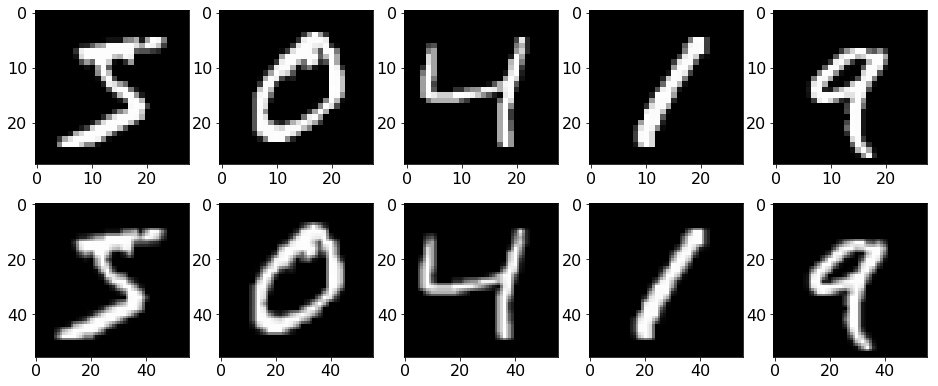

In [19]:
plt.figure(figsize=(16,6.5))
num_images = 5
for i in range(num_images):
    plt.subplot(2,num_images,i+1); 
    plt.imshow(x_train_3c[i,:,:,0], cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1); 
    plt.imshow(x_train_3c_exp[i,:,:,0], cmap='gray')
    
# plt.imshow((x_train_3c[0,:,:,0]), cmap='gray'); plt.show()
# plt.imshow((x_train_3c_exp[0,:,:,0]), cmap='gray'); plt.show()

OK, so now we have our high resolution interpolated images. Let's run the transfer model and see if it was all worth it.

In [28]:
#################################################################
############## Transfer Model 1 (Fixed+) #########################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))

# add a global spatial average pooling layer
x = base_model.output

# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer=mypotim, loss='binary_crossentropy', metrics=["accuracy"])

In [23]:
num_images_test = x_test.shape[0]
new_shape_test_exp = (num_images_test, len(new_x_values), len(new_y_values), 3)

x_test_3c_exp = np.zeros(new_shape_test_exp)

for i in range(x_test.shape[0]):
    
    interp_fn = interp2d(orig_x_ind, orig_y_ind, x_test[i,:,:,0])
    
    interp_image = interp_fn(new_x_values, new_y_values)
    
    x_test_3c_exp[i, :, :, 0] = interp_image 
    x_test_3c_exp[i, :, :, 1] = interp_image 
    x_test_3c_exp[i, :, :, 2] = interp_image 

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        x_train_3c_exp,  
        y_train_enc,
        batch_size=batch_size)

In [29]:
history = model_transfer.fit_generator(train_generator, x_train_3c_exp.shape[0] // batch_size, \
                                    epochs=20, verbose=1, validation_data=(x_test_3c_exp, y_test_enc))
model_transfer.save_weights('./models/transfer_architecture_1.h5')
pd.DataFrame(history.history).to_csv('./models/transfer_architecture_1.csv', index=True)

Epoch 1/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0492 - acc: 0.9826 - val_loss: 1.1443 - val_acc: 0.9188
Epoch 2/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0222 - acc: 0.9923 - val_loss: 1.2141 - val_acc: 0.9160
Epoch 3/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0191 - acc: 0.9935 - val_loss: 1.2613 - val_acc: 0.9140
Epoch 4/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0169 - acc: 0.9942 - val_loss: 1.2899 - val_acc: 0.9136
Epoch 5/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0159 - acc: 0.9945 - val_loss: 1.2730 - val_acc: 0.9145
Epoch 6/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0145 - acc: 0.9950 - val_loss: 1.3795 - val_acc: 0.9077
Epoch 7/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0132 - acc: 0.9954 - val_loss: 1.5834 - val_acc: 0.8956
Epoch 8/20
468/468 [==============================] - 28s 59ms

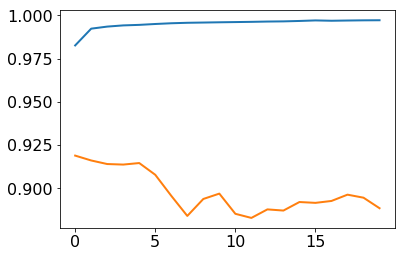

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [36]:
print(len(base_model.layers))
base_model.layers

19


In [39]:
base_model.layers[:15]

In [40]:
#################################################################
############## Transfer Model 2 #################################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))

# add a global spatial average pooling layer
x = base_model.output

# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

freeze_layer = 15

### Freeze layers ###
for layer in base_model.layers[:freeze_layer]:
    layer.trainable = False
    
for layer in base_model.layers[freeze_layer:]:
    layer.trainable = True

# mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer=mypotim, loss='binary_crossentropy', metrics=["accuracy"])

In [41]:
history = model_transfer.fit_generator(train_generator, x_train_3c_exp.shape[0] // batch_size, \
                                    epochs=20, verbose=1, validation_data=(x_test_3c_exp, y_test_enc))
model_transfer.save_weights('./models/transfer_architecture_2.h5')
pd.DataFrame(history.history).to_csv('./models/transfer_architecture_2.csv', index=True)

Epoch 1/20
468/468 [==============================] - 35s 76ms/step - loss: 0.0305 - acc: 0.9902 - val_loss: 0.1414 - val_acc: 0.9906
Epoch 2/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0089 - acc: 0.9976 - val_loss: 0.0704 - val_acc: 0.9953
Epoch 3/20
468/468 [==============================] - 35s 74ms/step - loss: 0.0074 - acc: 0.9980 - val_loss: 0.0690 - val_acc: 0.9956
Epoch 4/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0064 - acc: 0.9984 - val_loss: 0.0648 - val_acc: 0.9958
Epoch 5/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0060 - acc: 0.9984 - val_loss: 0.0408 - val_acc: 0.9973
Epoch 6/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0047 - acc: 0.9988 - val_loss: 0.0771 - val_acc: 0.9949
Epoch 7/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0045 - acc: 0.9988 - val_loss: 0.1197 - val_acc: 0.9922
Epoch 8/20
468/468 [==============================] - 35s 75ms

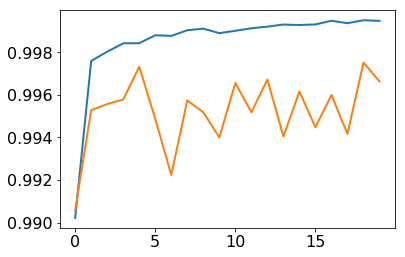

In [42]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

### Exercise for the reader

Download the Kaggle data for the cats and dogs dataset using their API: https://github.com/Kaggle/kaggle-api

Competition information for cats vs dogs here: https://www.kaggle.com/c/dogs-vs-cats/rules

Challenge: create a transfer learning model that can distinguish cats vs. dogs using vgg-16 or another pre-trained model of your choice from the Keras library.